Using device: cuda:1

Training with sequence_length=20, num_layers=1, nhead=4
Epoch  1: Train Loss = 1.9493, Val Loss = 1.6911, Val Accuracy = 0.4910
Epoch  2: Train Loss = 1.7236, Val Loss = 1.6101, Val Accuracy = 0.5108
Epoch  3: Train Loss = 1.6688, Val Loss = 1.5786, Val Accuracy = 0.5182
Epoch  4: Train Loss = 1.6376, Val Loss = 1.5514, Val Accuracy = 0.5255
Epoch  5: Train Loss = 1.6167, Val Loss = 1.5322, Val Accuracy = 0.5304
Epoch  6: Train Loss = 1.6011, Val Loss = 1.5228, Val Accuracy = 0.5320
Epoch  7: Train Loss = 1.5874, Val Loss = 1.5109, Val Accuracy = 0.5359
Epoch  8: Train Loss = 1.5762, Val Loss = 1.4981, Val Accuracy = 0.5382
Epoch  9: Train Loss = 1.5661, Val Loss = 1.4941, Val Accuracy = 0.5406
Epoch 10: Train Loss = 1.5586, Val Loss = 1.4841, Val Accuracy = 0.5407
Epoch 11: Train Loss = 1.5511, Val Loss = 1.4792, Val Accuracy = 0.5430
Epoch 12: Train Loss = 1.5442, Val Loss = 1.4743, Val Accuracy = 0.5454
Epoch 13: Train Loss = 1.5382, Val Loss = 1.4652, Val Accu

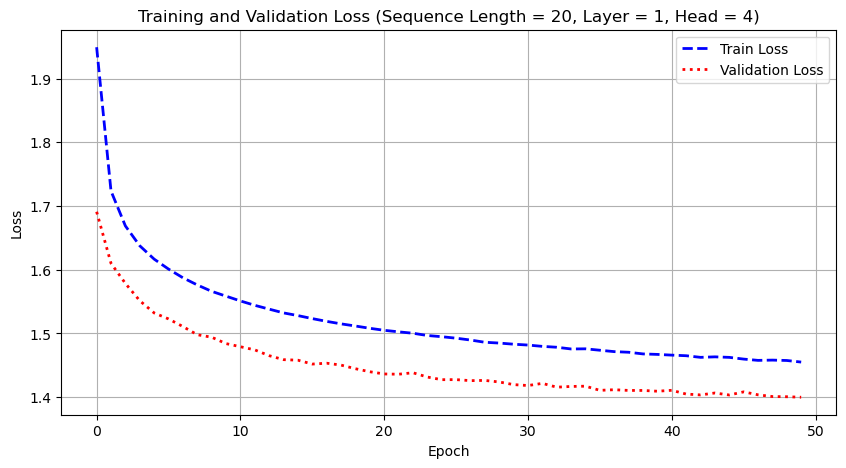

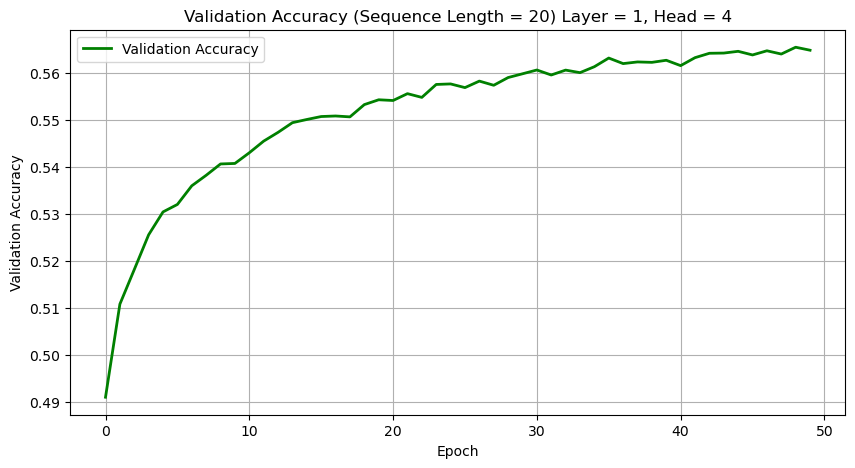

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import requests
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torch.amp import GradScaler, autocast




# ================================
# Device Configuration
# ================================
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




# ================================
# Step 1: Download the Dataset
# ================================
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text




# ================================
# Step 2: Create Character Mappings
# ================================
chars = sorted(list(set(text)))
vocab_size = len(chars)
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}




# ============================================================
# Helper Functions to Create the Dataset and DataLoaders
# ============================================================
def create_dataset(text, sequence_length):
    encoded_text = [char_to_int[ch] for ch in text]
    sequences = []
    targets = []
    for i in range(len(encoded_text) - sequence_length):
        seq = encoded_text[i:i+sequence_length]
        target = encoded_text[i+sequence_length]
        sequences.append(seq)
        targets.append(target)
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    return sequences, targets




class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets




    def __len__(self):
        return len(self.sequences)




    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]




def get_dataloaders(sequence_length, batch_size=256):
    sequences, targets = create_dataset(text, sequence_length)
    dataset = CharDataset(sequences, targets)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True)
    return train_loader, test_loader




# ================================
# Positional Encoding Module
# ================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)




    def forward(self, x):
        return x + self.pe[:, :x.size(1)]




# ================================
# Transformer Model Definition
# ================================
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_layers=2, nhead=2):
        super(TransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)




    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        logits = self.fc(x)
        return logits




# ================================
# Utility Function: Parameter Count
# ================================
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)




# ================================
# Training Function
# ================================
def train_experiment(sequence_length=20, epochs=50, batch_size=256, embed_dim=128, num_layers=2, nhead=2, lr=0.001):
    print(f"\nTraining with sequence_length={sequence_length}, num_layers={num_layers}, nhead={nhead}")
    train_loader, test_loader = get_dataloaders(sequence_length, batch_size)
    
    model = TransformerModel(vocab_size, embed_dim, num_layers, nhead).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler('cuda')  # Updated to new syntax
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    start_time = time.time()
    
    for epoch in range(1, epochs+1):
        model.train()
        epoch_train_loss = 0
        for batch_inputs, batch_targets in train_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            with autocast('cuda'):  # Updated to new syntax
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += loss.item() * batch_inputs.size(0)
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_inputs, batch_targets in test_loader:
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                with autocast('cuda'):  # Updated to new syntax
                    outputs = model(batch_inputs)
                    loss = criterion(outputs, batch_targets)
                epoch_val_loss += loss.item() * batch_inputs.size(0)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == batch_targets).sum().item()
                total += batch_targets.size(0)
        avg_val_loss = epoch_val_loss / len(test_loader.dataset)
        val_losses.append(avg_val_loss)
        accuracy = correct / total
        val_accuracies.append(accuracy)
        
        print(f"Epoch {epoch:2d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {accuracy:.4f}")
    
    end_time = time.time()
    exec_time = end_time - start_time
    param_count = count_parameters(model)
    
    print(f"Training completed in {exec_time:.2f} seconds")
    print(f"Model Parameter Count: {param_count}")
    
    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "execution_time": exec_time,
        "param_count": param_count,
        "model": model
    }
    return results




# ================================
# Run Experiment
# ================================
results = train_experiment(sequence_length=20, epochs=50, num_layers=1, nhead=4)




# ================================
# Plotting the Results
# ================================
plt.figure(figsize=(10, 5))
plt.plot(results["train_losses"], label="Train Loss", color="blue", linestyle="--", linewidth=2)
plt.plot(results["val_losses"], label="Validation Loss", color="red", linestyle=":", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Sequence Length = 20, Layer = 1, Head = 4)")
plt.legend()
plt.grid(True)
plt.show()




plt.figure(figsize=(10, 5))
plt.plot(results["val_accuracies"], label="Validation Accuracy", color="green", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy (Sequence Length = 20) Layer = 1, Head = 4")
plt.legend()
plt.grid(True)
plt.show()





